## ***Question 2, HW5***

In [1]:
! pip install torch torchvision transformers datasets peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
! pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.4.0
    Uninstalling urllib3-2.4.0:
      Successfully uninstalled urllib3-2.4.0
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing installation: req

In [3]:
! pip install peft accelerate

### ***Import Required Libraries***

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
#-----------------
from torch.utils.data import Dataset
from transformers import CLIPProcessor, CLIPModel
import torchattacks
from sklearn.metrics import accuracy_score
from tqdm import tqdm
#-----------------
import torch.nn as nn
from peft.tuners.lora import Linear as LoRALinear
from peft import LoraConfig
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    )
])

In [6]:
dataset = datasets.CIFAR10(root="./data", train=True, download=True)
train_dataset, val_dataset = random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True)

100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]


### ***Showing some samples of the dataset***

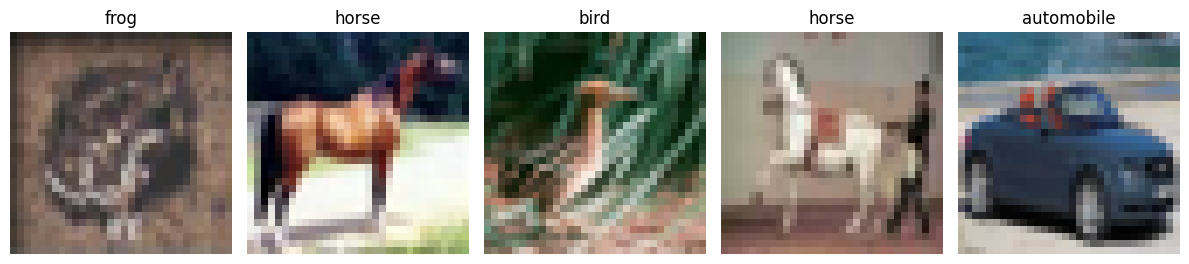

In [7]:
class_dict = dict()
for i in range(10):
    class_dict[i] = dataset.classes[i]

mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)

fix, axes = plt.subplots(1, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img)
    ax.set_title(class_dict[label])
    ax.axis('off')
plt.tight_layout()
plt.show()


***

### ***Preparing the model***

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
model.eval()

sentence_labels = [f"a photo of a {label}" for label in dataset.classes]
with torch.no_grad():
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    text_tokens = processor(text=sentence_labels, return_tensors="pt", padding=True).to(device)
    text_features = model.get_text_features(**text_tokens)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

### ***Showing some samples, true labels and their correseponding prediction***

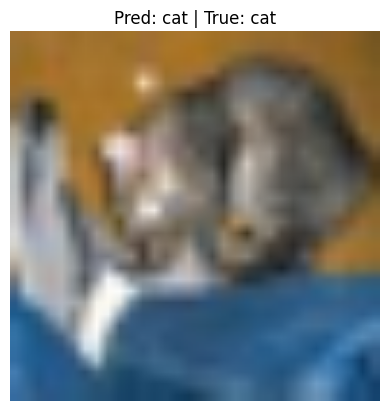

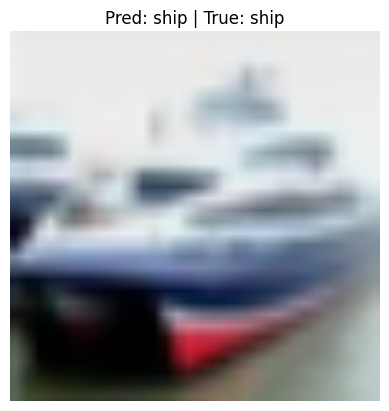

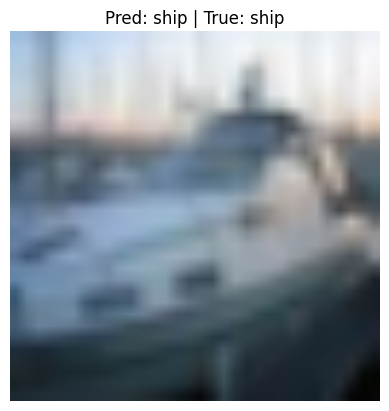

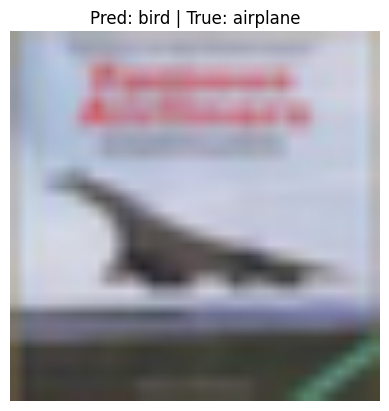

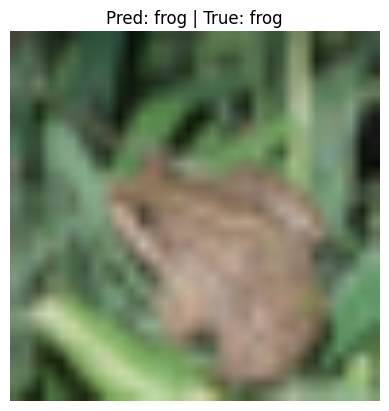

In [9]:
n = 5
images = [transform(test_dataset[i][0]) for i in range(n)]
image_batch = torch.stack(images).to(device)

with torch.no_grad():
    image_features = model.get_image_features(pixel_values=image_batch)
    image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
    similarity = image_features @ text_features.T
    predicted_ids = similarity.argmax(dim=-1)

image_labels = [test_dataset[i][1] for i in range(n)]

for i in range(n):
    img = images[i]*std+mean
    plt.imshow(np.transpose(img.numpy(), [1, 2, 0]))
    plt.axis('off')
    plt.title(f"Pred: {class_dict[predicted_ids[i].item()]} | True: {class_dict[image_labels[i]]}")
    plt.show()


### ***PGD model for attack***

In [10]:
resnet_20 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
resnet_20.eval().to(device)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 24.2MB/s

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

***

In [11]:
class TransformedDataset(Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        image = self.transform(image)
        return image, label

testset = TransformedDataset(test_dataset, transform)
test_loader = DataLoader(testset, batch_size=10, shuffle=False)

trainset = TransformedDataset(train_dataset, transform)
train_loader = DataLoader(trainset, batch_size=10, shuffle=True)

valset = TransformedDataset(val_dataset, transform)
val_loader = DataLoader(valset, batch_size=10, shuffle=False)

In [14]:
# Evaluation Fucntion for evaluting accuracy on clean and adverserial images
def eval_CLIP(model, loader, text_features, pgd=None):
    model.eval()
    correct = 0
    total = 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        if pgd != None:
            images = pgd(images, labels)
        with torch.no_grad():
            image_features = model.get_image_features(pixel_values=images)
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
            logits = image_features @ text_features.T
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Accuracy on test set with attack = {pgd!=None}: {acc}")

In [15]:
pgd = torchattacks.PGD(
    resnet_20,
    eps=8/255,
    alpha=2/255,
    steps=7
)

In [38]:
eval_CLIP(model, test_loader, text_features)
eval_CLIP(model, test_loader, text_features, pgd)

100%|██████████| 1000/1000 [00:41<00:00, 24.11it/s]


Accuracy on test set with attack = False: 0.8783


100%|██████████| 1000/1000 [06:24<00:00,  2.60it/s]

Accuracy on test set with attack = True: 0.5495


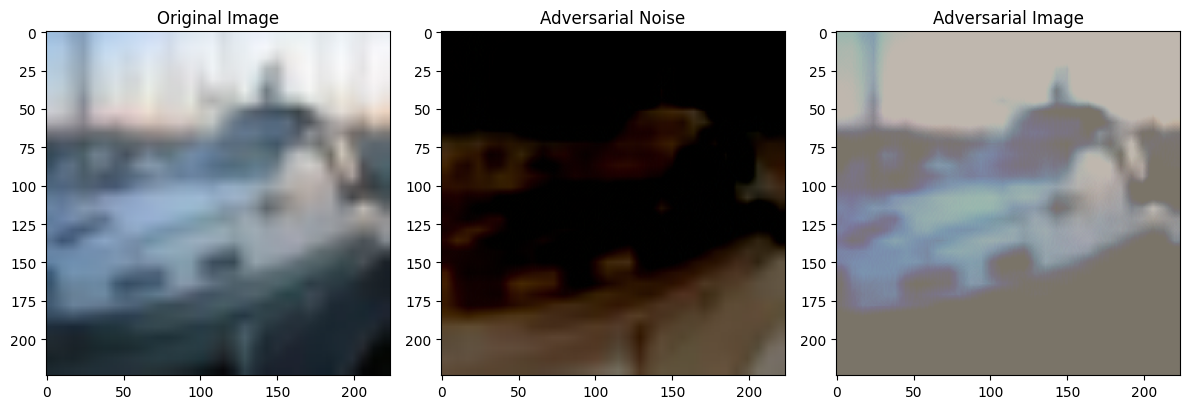

In [25]:
def unnormalize(img_tensor):
    return (img_tensor * std + mean)

adv_images = pgd(image_batch, torch.tensor(image_labels))
image_to_show = 2
adv_img = unnormalize(adv_images[image_to_show].cpu()).permute(1, 2, 0).numpy()
org_image = unnormalize(transform(test_dataset[image_to_show][0])).permute(1, 2, 0).numpy()

fix, axes = plt.subplots(1, 3, figsize=(12, 6))

axes[0].imshow(org_image)
axes[0].set_title("Original Image")

axes[1].imshow(adv_img - org_image)
axes[1].set_title("Adversarial Noise")

axes[2].imshow(adv_img)
axes[2].set_title("Adversarial Image")

plt.tight_layout()
plt.show()

***

### ***LoRA method***

In [31]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

for p in model.parameters():
    p.requires_grad = False

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="FEATURE_EXTRACTION"
)

def prepare_LoRA_layers(model, config):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and (name.endswith("self_attn.q_proj") or name.endswith("self_attn.v_proj")):
            parent_name, layer_name = name.rsplit(".", 1)
            parent = dict(model.named_modules())[parent_name]
            orig = getattr(parent, layer_name)

            lora = LoRALinear(
                base_layer=orig,
                adapter_name="default",
                r=config.r,
                lora_alpha=config.lora_alpha,
                lora_dropout=config.lora_dropout,
                bias=False
            )

            with torch.no_grad():
                lora.base_layer.weight.copy_(orig.weight)
            setattr(parent, layer_name, lora)

In [32]:
prepare_LoRA_layers(model.vision_model, lora_config)

for n, p in model.named_parameters():
    p.requires_grad = ("lora_" in n)

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
loss_fn = CrossEntropyLoss()
model.train()
q = 0
for images, labels in train_loader:
    q += 1
    if q >= 1000:
        break
    images, labels = images.to(device), labels.to(device)
    adv_images = pgd(images, labels)
    feats = model.get_image_features(pixel_values=adv_images)
    feats = feats / feats.norm(dim=-1, keepdim=True)
    logits = feats @ text_features.T
    loss = loss_fn(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f"loss: {loss.item()}")

loss: 2.0258126258850098


In [33]:
eval_CLIP(model, test_loader, text_features)
eval_CLIP(model, test_loader, text_features, pgd)

100%|██████████| 1000/1000 [00:41<00:00, 24.17it/s]


Accuracy on test set with attack = False: 0.8221


100%|██████████| 1000/1000 [06:25<00:00,  2.59it/s]

Accuracy on test set with attack = True: 0.7075


***

### ***TeCoA method***

In [34]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4)
loss_fn = CrossEntropyLoss()
tau = 0.07

def pgd_tecoa(images, labels, iters=5, eps=2/255, alpha=0.5/255):
    ori = images.detach()
    adv = images.clone().detach().requires_grad_(True)
    for _ in range(iters):
        feats = model.get_image_features(pixel_values=adv)
        feats = F.normalize(feats, dim=-1)
        logits = feats @ text_features.T / tau
        loss = loss_fn(logits, labels)
        grad = torch.autograd.grad(loss, adv)[0]
        adv = adv + alpha * grad.sign()
        delta = torch.clamp(adv - ori, -eps, eps)
        adv = torch.clamp(ori + delta, 0.0, 1.0).detach().requires_grad_(True)
    return adv.detach()

model.train()
running = 0.0
q = 0
for images, labels in train_loader:
    q += 1
    if q >= 1000:
      break
    images, labels = images.to(device), labels.to(device)
    feats_clean = model.get_image_features(pixel_values=images)
    feats_clean = F.normalize(feats_clean, dim=-1)
    logits_clean= feats_clean @ text_features.T / tau
    loss_clean  = loss_fn(logits_clean, labels)
    adv_images  = pgd_tecoa(images, labels)
    feats_adv   = model.get_image_features(pixel_values=adv_images)
    feats_adv   = F.normalize(feats_adv, dim=-1)
    logits_adv  = feats_adv @ text_features.T / tau
    loss_adv    = loss_fn(logits_adv, labels)
    loss = 0.5*loss_clean + 0.5*loss_adv
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running += loss.item()*images.size(0)

avg_loss = running/len(train_loader.dataset)
model.eval()
print(f"avg loss: {avg_loss}")

avg loss: 0.18829028620943428


In [35]:
eval_CLIP(model, test_loader, text_features)
eval_CLIP(model, test_loader, text_features, pgd)

100%|██████████| 1000/1000 [00:41<00:00, 24.14it/s]


Accuracy on test set with attack = False: 0.9224


100%|██████████| 1000/1000 [06:25<00:00,  2.60it/s]

Accuracy on test set with attack = True: 0.7973
